In [1]:
from astropy.io import fits
from astropy import constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import voigt_profile
from lmfit import Model, Parameters
from lmfit.models import PolynomialModel
from voigt_fit_lib_draft import *

Load in the spectrum

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/FUV/'

In [3]:
spec = fits.open(rootdir + 'PG1522+101_FUV_wavecal_new.fits')
nodes = fits.open(rootdir + 'PG1522+101_FUV_wavecal_new_nodes.fits')
ids = fits.open(rootdir + 'PG1522+101_FUV_wavecal_new_identifications.fits')

In [4]:
wav, flux, err = load_spec(spec)

(-1e-16, 9e-15)

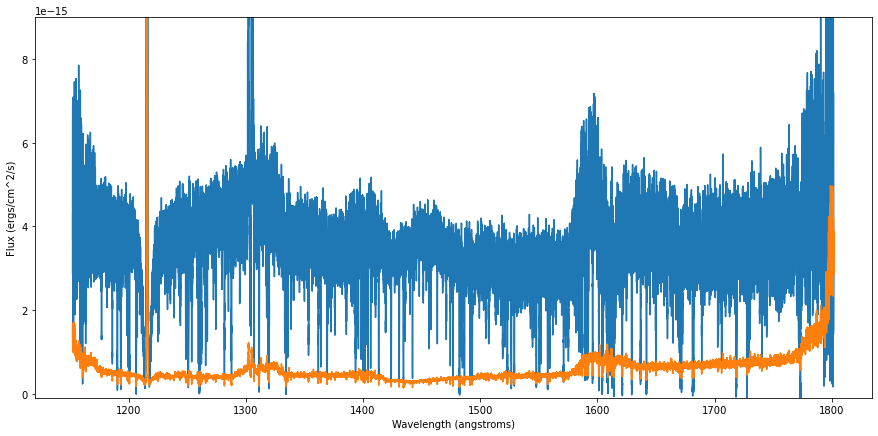

In [5]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav, flux)
ax.plot(wav, err)

ax.set_xlabel('Wavelength (angstroms)')
ax.set_ylabel('Flux (ergs/cm^2/s)')

ax.set_ylim(-1e-16, 9e-15)

Continuum normalize the flux and error

In [6]:
flux_norm, err_norm = cont_norm(nodes, wav, flux, err)

(-0.1, 3.0)

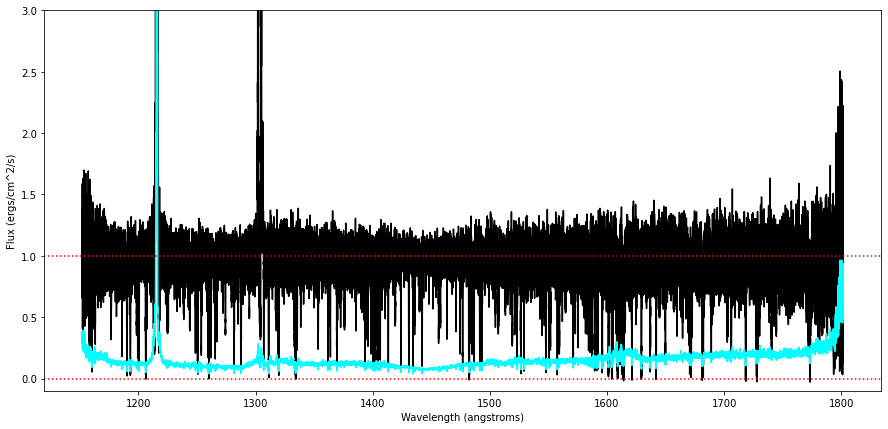

In [7]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav, flux_norm, color='black')
ax.plot(wav, err_norm, color='cyan')
ax.axhline(0, color='red', linestyle=':')
ax.axhline(1, color='red', linestyle=':')


ax.set_xlabel('Wavelength (angstroms)')
ax.set_ylabel('Flux (ergs/cm^2/s)')

ax.set_ylim(-0.1,3)

Grab line identifications

In [8]:
ion_1 = ion('HI1025', 51, 'FUV')

In [9]:
ion_1.name, ion_1.sys_idx, ion_1.detector

('HI1025', 51, 'FUV')

In [10]:
ions_table = np.loadtxt('/Users/thepoetoftwilight/Documents/CUBS/pabs0/data/linelists/atom.dat', dtype=str)

In [11]:
ion_name, ion_wav0_rest, ion_z, ion_wav0_obs, ion_f, ion_gamma = grab_ion_info(ids, ions_table, 
                                                                               sys_idx=51, ion_idx=2)

In [12]:
ion_name, ion_wav0_rest

('HI', 1025.7222900390625)

Compute line-of-sight velocities for the line

In [13]:
ion_v, ion_v_obs, ion_flux_obs, ion_err_obs = los_velocities_slice(wav, flux_norm, err_norm,
                                                                   ion_wav0_obs, 
                                                                   ion_v_min=-200, ion_v_max=200)

Find the LSF for the sampled wavelength which is closest to the redshifted wavelength of the line. Begin with loading in the relevant LSFs

In [14]:
lsf_fits = fits.open(rootdir + 'PG1522_COS_FUV_wavcal2022_lsf_ZQ.fits')

In [15]:
lsf_wavs, lsf_dat = lsf_fits_process(lsf_fits)
ion_lsf = grab_ion_lsf(lsf_wavs, lsf_dat, ion_wav0_obs)
ion_lsf_pix_v = gen_lsf_pix_v(ion_v, ion_lsf)

Text(0, 0.5, 'LSF')

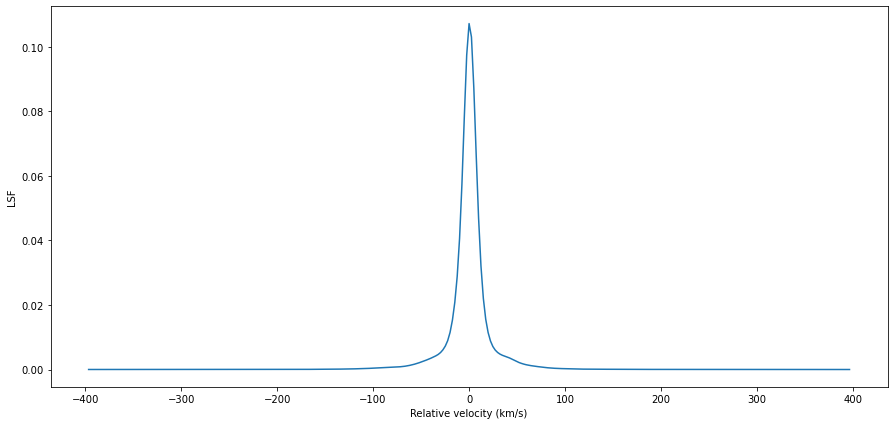

In [16]:
fig, ax = plt.subplots(1, figsize=(15, 7))

ax.plot(ion_lsf_pix_v, ion_lsf)

ax.set_xlabel('Relative velocity (km/s)')
ax.set_ylabel('LSF')

In [17]:
ion_lsf_convolve = True

Renormalize the continuum

In [18]:
ion_v_blue_bound = -90
ion_v_red_bound = 110

Text(0, 0.5, 'Continuum normalized flux')

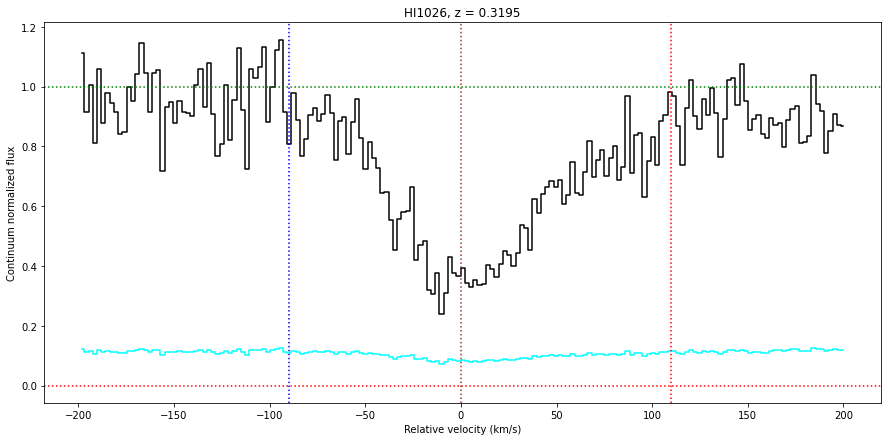

In [19]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.step(ion_v_obs, ion_flux_obs, color='black', where='mid')
ax.step(ion_v_obs, ion_err_obs, color='cyan', where='mid')

ax.axvline(ion_v_blue_bound, color='blue', linestyle=':')
ax.axvline(ion_v_red_bound, color='red', linestyle=':')

ax.axhline(0, color='red', linestyle=':')
ax.axhline(1, color='green', linestyle=':')
ax.axvline(0, color='brown', linestyle=':')

#ax.errorbar(ion_v_obs, ion_flux_obs, yerr = ion_err_obs, color='black', linestyle='', lw=1)

ax.set_title(ion_name + str(int(np.round(ion_wav0_rest))) + ', z = ' + str(round(ion_z, 4)))

ax.set_xlabel('Relative velocity (km/s)')
ax.set_ylabel('Continuum normalized flux')

In [20]:
degree=1
ion_flux_obs_renorm, ion_err_obs_renorm = cont_renorm(ion_v_obs, ion_flux_obs, ion_err_obs, 
                                                      ion_v_blue_bound, ion_v_red_bound, degree=degree)

Text(0, 0.5, 'Continuum normalized flux')

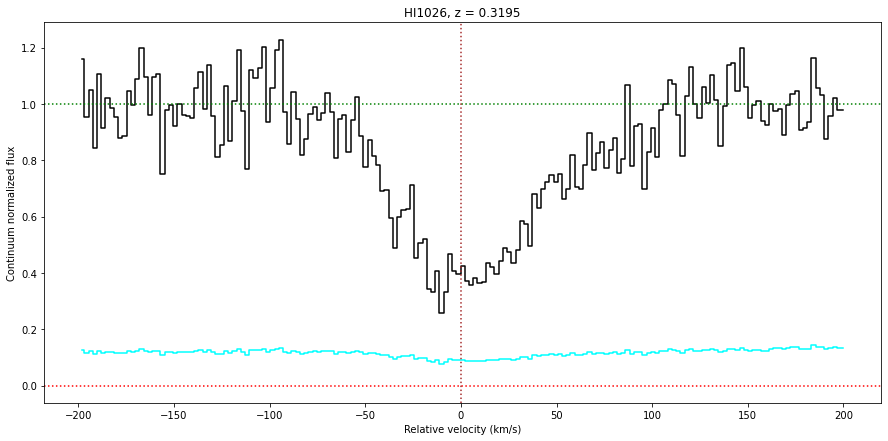

In [21]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.step(ion_v_obs, ion_flux_obs_renorm, color='black', where='mid')
ax.step(ion_v_obs, ion_err_obs_renorm, color='cyan', where='mid')

ax.axhline(0, color='red', linestyle=':')
ax.axhline(1, color='green', linestyle=':')
ax.axvline(0, color='brown', linestyle=':')

#ax.errorbar(ion_v_obs, ion_flux_obs, yerr = ion_err_obs, color='black', linestyle='', lw=1)

ax.set_title(ion_name + str(int(np.round(ion_wav0_rest))) + ', z = ' + str(round(ion_z, 4)))

ax.set_xlabel('Relative velocity (km/s)')
ax.set_ylabel('Continuum normalized flux')

Let's try guessing first

In [22]:
# 1 component guess
#ion_guess_params = np.array([[14.43, 34, 5]])

# 2 component guess
ion_guess_params = np.array([[14.3, 30, 0], [13.8, 40, 10]])

In [23]:
component_fluxes, best_fit_flux = comp_model_spec_gen(ion_v_obs, 
                                                      ion_guess_params, 
                                                      wav0_obs = ion_wav0_obs, f = ion_f, gamma = ion_gamma, 
                                                      lsf_convolve = ion_lsf_convolve, lsf = ion_lsf,
                                                      v_lsf = ion_lsf_pix_v)

In [24]:
n_components = np.shape(ion_guess_params)[0]

In [25]:
colors = ['lightgray', 'pink', 'greenyellow', 'sandybrown']

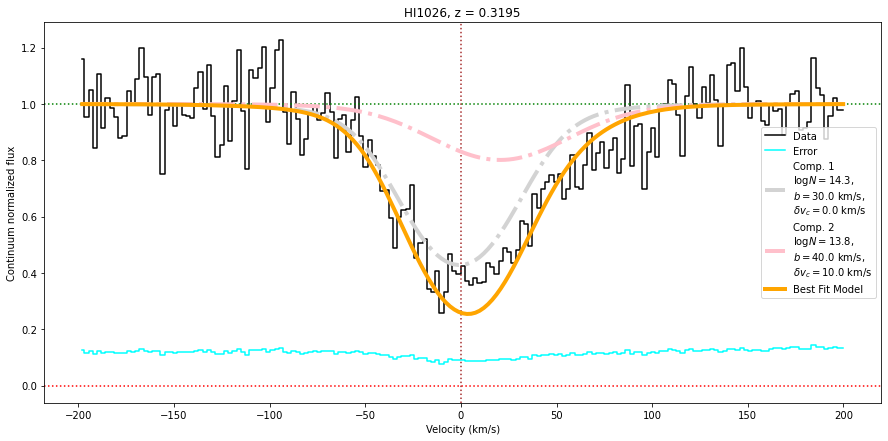

In [26]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.step(ion_v_obs, ion_flux_obs_renorm, color='black', where='mid', label='Data')
ax.step(ion_v_obs, ion_err_obs_renorm, color='cyan', where='mid', label='Error')
ax.axhline(0, color='red', linestyle=':')
ax.axhline(1, color='green', linestyle=':')
ax.axvline(0, color='brown', linestyle=':')

if(n_components == 1):
    
    ax.plot(ion_v_obs, component_fluxes[i,:], 
            label='Best fit model'.format(i+1) +  '\n'
            r'$\logN = $' + str(np.round(ion_guess_params[i,0], 2)) + ', \n' +
            r'$b = $' + str(np.round(ion_guess_params[i,1], 2)) + ' km/s' + ', \n' +
            r'$\delta v_c = $' + str(np.round(ion_guess_params[i,2], 2)) + ' km/s',
            lw=4, color='orange')
    
else:

    for i in range(n_components):

        ax.plot(ion_v_obs, component_fluxes[i,:], 
                label='Comp. {}'.format(i+1) +  '\n'
                r'$\logN = $' + str(np.round(ion_guess_params[i,0], 2)) + ', \n' +
                r'$b = $' + str(np.round(ion_guess_params[i,1], 2)) + ' km/s' + ', \n' +
                r'$\delta v_c = $' + str(np.round(ion_guess_params[i,2], 2)) + ' km/s',
                lw=4, color=colors[i], linestyle='-.')

    ax.plot(ion_v_obs, best_fit_flux,
            lw=4, color='orange', label='Best Fit Model')

ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Continuum normalized flux')

ax.set_title(ion_name + str(int(np.round(ion_wav0_rest))) + ', z = ' + str(round(ion_z, 4)))
ax.legend()

Now, let's fit

In [27]:
result, fit_values, fit_errs, component_fluxes, best_fit_flux =  fit_model(ion_v_obs, 
                                                                           ion_flux_obs_renorm, ion_err_obs_renorm, 
                                                                           ion_guess_params, ion_wav0_obs, ion_f, 
                                                                           ion_gamma, ion_lsf_convolve, ion_lsf, ion_lsf_pix_v)

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/lmfit/model.py:990: UserWarning: The keyword argument wav0_obs does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/lmfit/model.py:990: UserWarning: The keyword argument f does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/lmfit/model.py:990: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/lmfit/model.py:990: UserWarning: The keyword argument lsf_convolve does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The

In [28]:
result

Plot both components along with the superposition

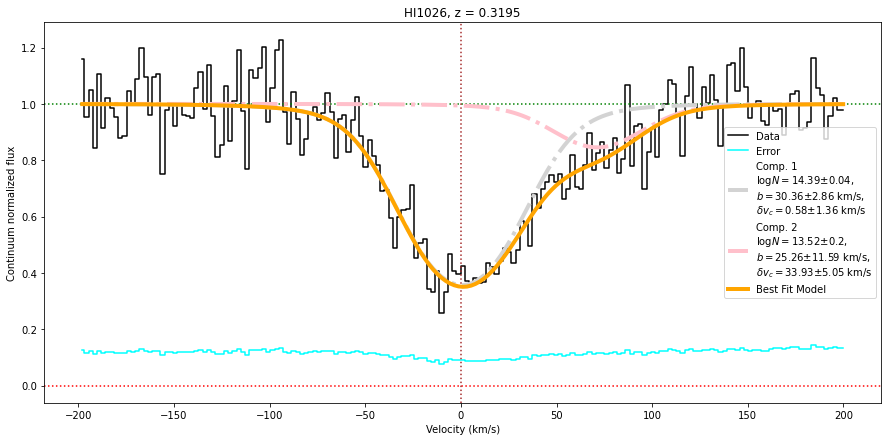

In [29]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.step(ion_v_obs, ion_flux_obs_renorm, color='black', where='mid', label='Data')
ax.step(ion_v_obs, ion_err_obs_renorm, color='cyan', where='mid', label='Error')
ax.axhline(0, color='red', linestyle=':')
ax.axhline(1, color='green', linestyle=':')
ax.axvline(0, color='brown', linestyle=':')

if(n_components == 1):
    
    ax.plot(ion_v_obs, component_fluxes[i,:], 
            label='Best fit model'.format(i+1) +  '\n'
            r'$\logN = $' + str(np.round(fit_values[i,0], 2)) + r'$\pm$' + str(np.round(fit_errs[i,0], 2)) + ', \n' +
            r'$b = $' + str(np.round(fit_values[i,1], 2)) +  r'$\pm$' + str(np.round(fit_errs[i,1], 2)) + ' km/s' + ', \n' +
            r'$\delta v_c = $' + str(np.round(fit_values[i,2], 2)) +  r'$\pm$' + str(np.round(fit_errs[i,2], 2)) + ' km/s',
            lw=4, color='orange')
    
else:

    for i in range(n_components):

        ax.plot(ion_v_obs, component_fluxes[i,:], 
                label='Comp. {}'.format(i+1) +  '\n'
                r'$\logN = $' + str(np.round(fit_values[i,0], 2)) + r'$\pm$' + str(np.round(fit_errs[i,0], 2)) + ', \n' +
                r'$b = $' + str(np.round(fit_values[i,1], 2)) +  r'$\pm$' + str(np.round(fit_errs[i,1], 2)) + ' km/s' + ', \n' +
                r'$\delta v_c = $' + str(np.round(fit_values[i,2], 2)) +  r'$\pm$' + str(np.round(fit_errs[i,2], 2)) + ' km/s',
                lw=4, color=colors[i], linestyle='-.')

    ax.plot(ion_v_obs, best_fit_flux,
            lw=4, color='orange', label='Best Fit Model')

ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Continuum normalized flux')

ax.set_title(ion_name + str(int(np.round(ion_wav0_rest))) + ', z = ' + str(round(ion_z, 4)))
ax.legend()